In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

In [ ]:
CSV_PATH = "/content/data.csv"

df = pd.read_csv(CSV_PATH, encoding = "latin1")

print("Dataset shape:", df.shape)
df.head()

/tmp/ipython-input-2483902941.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_PATH, encoding = "latin1")


Dataset shape: (435742, 13)


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [ ]:
no2_col = "no2"

# Convert to numeric (handle strings, NaN, odd values)
no2_data = pd.to_numeric(df[no2_col], errors="coerce")

# Drop missing values
no2_data = no2_data.dropna()

# Keep valid non-negative values
no2_data = no2_data[no2_data >= 0]

# Trim extreme outliers
low, high = np.percentile(no2_data, [0.5, 99.5])
no2_data = no2_data[(no2_data >= low) & (no2_data <= high)]

# Convert to NumPy array
no2_data = no2_data.to_numpy(dtype=np.float64)

print("NO2 cleaned count:", len(no2_data))
print("NO2 min/max:", float(no2_data.min()), float(no2_data.max()))

NO2 cleaned count: 415688
NO2 min/max: 4.0 111.4


In [ ]:
roll_num = 102303881

a_r = 0.05 * (roll_num % 7)
b_r = 0.3 * ((roll_num % 5) + 1)

z = no2_data + (a_r * np.sin(b_r * no2_data))

print("a_r =", a_r)
print("b_r =", b_r)
print("z count:", len(z), "min:", z.min(), "max:", z.max())

a_r = 0.05
b_r = 0.6
z count: 415688 min: 4.033773159027557 max: 111.36189487456122


In [ ]:
mu_est = float(np.mean(z))

var_est = float(np.mean((z - mu_est) ** 2))
sigma_est = float(np.sqrt(var_est))

lambda_est = float(1.0 / (2.0 * var_est))
c_est = float(np.sqrt(lambda_est / np.pi))

print("Estimated mean (mu)     =", mu_est)
print("Estimated variance      =", var_est)
print("Estimated sigma         =", sigma_est)
print("Estimated lambda        =", lambda_est)
print("Estimated c             =", c_est)


Estimated mean (mu)     = 25.305371201994745
Estimated variance      = 255.90315702980914
Estimated sigma         = 15.996973370916423
Estimated lambda        = 0.001953864132835833
Estimated c             = 0.024938610020238998


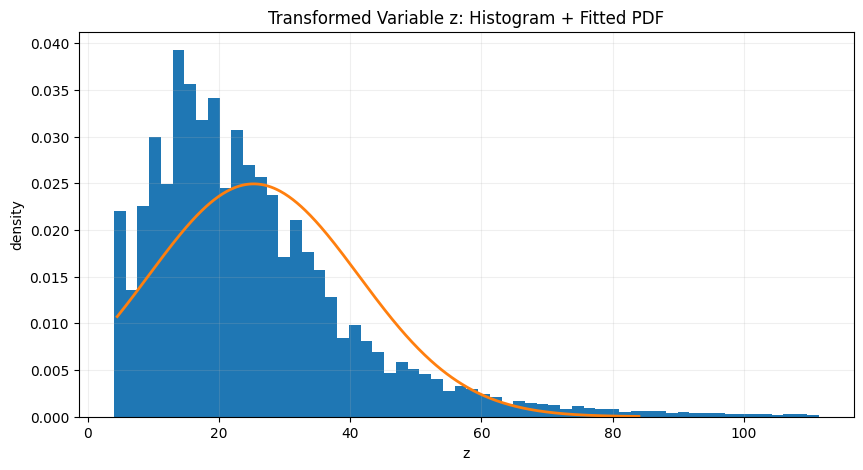

In [ ]:
def pdf_est(z_vals, lam, mu, c):
    return c * np.exp(-lam * (z_vals - mu) ** 2)

# Plot range
z_lo, z_hi = np.percentile(z, [1, 99])
z_grid = np.linspace(z_lo, z_hi, 500)

pdf_vals = pdf_est(z_grid, lambda_est, mu_est, c_est)

plt.figure(figsize=(10, 5))
plt.hist(z, bins=60, density=True)
plt.plot(z_grid, pdf_vals, linewidth=2)
plt.title("Transformed Variable z: Histogram + Fitted PDF")
plt.xlabel("z")
plt.ylabel("density")
plt.grid(True, alpha=0.2)
plt.show()


In [ ]:
summary = pd.DataFrame([{
    "roll_number": roll_num,
    "a_r": a_r,
    "b_r": b_r,
    "mu_hat": mu_est,
    "lambda_hat": lambda_est,
    "c_hat": c_est,
    "n_samples": len(z)
}])

summary

,roll_number,a_r,b_r,mu_hat,lambda_hat,c_hat,n_samples
0,102303881,0.05,0.6,25.305371,0.001954,0.024939,415688


In [ ]:
out_dir = Path("outputs")
out_dir.mkdir(exist_ok=True)

summary.to_csv(out_dir / "estimated_params.csv", index=False)

plt.figure(figsize=(10, 5))
plt.hist(z, bins=60, density=True)
plt.plot(z_grid, pdf_vals, linewidth=2)
plt.title("z Histogram + Fitted PDF")
plt.xlabel("z")
plt.ylabel("density")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.savefig(out_dir / "fit_plot.png", dpi=200)
plt.close()

print("Saved:", (out_dir / "estimated_params.csv").as_posix())
print("Saved:", (out_dir / "fit_plot.png").as_posix())


Saved: outputs/estimated_params.csv
Saved: outputs/fit_plot.png
